## Import Data and Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import scipy.optimize
from cvxopt import blas, solvers
import cvxopt as opt

In [2]:
path = "data\prices.txt"
df = pd.read_csv(path,delimiter= '\s+', index_col=False)
df.columns = ["PERMNO","date","TICKER","PRC","VOL","DLPRC","CFACPR"]
df.set_index("date",inplace=True)
df = df.drop(columns = ["DLPRC","CFACPR"])

#### See all 100 assets' first day price

In [3]:
firstday = df.index=="20080102"
day1 = df[firstday]
day1.index= pd.to_datetime(day1.index,format="%Y%m%d")
#day1

#### Since TICKER has duplications, we use PERMNO as column name; for convenience, we create a dictionary for searching purpose.

In [4]:
nums = day1["PERMNO"].values
names = day1["TICKER"].values
dict={}
for n,N in zip(names,nums):
    dict[n] = N
print(dict)

{'ORCL': '10104', 'MSFT': '10107', 'HON': '10145', 'EMC': '10147', 'DELL': '11081', 'KO': '11308', 'DD': '11703', 'XOM': '11850', 'GE': '12060', 'IBM': '12490', 'PEP': '13856', 'MO': '13901', 'COP': '13928', 'AMGN': '14008', 'SLB': '14277', 'CVX': '14541', 'AAPL': '14593', 'MRO': '15069', 'TXN': '15579', 'WYE': '15667', 'CVS': '17005', 'BRK': '83443', 'UTX': '17830', 'PG': '18163', 'CAT': '18542', 'CL': '18729', 'DE': '19350', 'BMY': '19393', 'BA': '19561', 'ABT': '20482', 'LMT': '21178', 'EXC': '21776', 'PFE': '21936', 'EMR': '22103', 'JNJ': '22111', 'MMM': '22592', 'MRK': '22752', 'SGP': '25013', 'DIS': '26403', 'HPQ': '27828', 'UN': '28310', 'IMO': '33099', 'OXY': '34833', 'WB': '36469', 'WFC': '38703', 'MCD': '43449', 'JPM': '47896', 'TGT': '49154', 'BK': '49656', 'LLY': '50876', 'FNM': '51043', 'MER': '52919', 'WMT': '55976', 'AXP': '59176', 'INTC': '59328', 'BAC': '59408', 'MDT': '60097', 'VZ': '65875', 'T': '66093', 'USB': '66157', 'HD': '66181', 'AIG': '66800', 'MS': '69032', '

In [5]:
dict["SPY"]

'84398'

# Q1:

### Benchmark asset: SPY
* Obtain prices ```Prices_SPY```
* Obtain returns ```Returns_SPY```
* Obtain variance of benchmark returns ```V```

In [6]:
SPY = df["TICKER"]=="SPY"
# obtain prices
Prices_SPY = df[SPY].drop(columns = ["PERMNO","TICKER","VOL"]).rename(columns={"PRC":"SPY"})
# obtain returns
Returns_SPY = Prices_SPY.astype(float).pct_change()
Returns_SPY.index= pd.to_datetime(Returns_SPY.index,format="%Y%m%d")
Returns_SPY = Returns_SPY.dropna()

In [7]:
# obtain variance
def VarianceSPY(start,window): # V
    '''
    start: start date of SPY data used
    return variance of SPY return from start date and 30 days forward
    '''
    V = Returns_SPY.iloc[start:start+window]
    return V.cov().values.item()

### Calculate Betas:
* To obtain Betas, we can either use ***Linear Regression*** or 
* For the i-th stock, calculate its ***CAPM $\beta^{i}$*** to the SPY exchange traded fund.
$$\beta^i = \frac{Cov(r^i,r^M)}{Var(r^M)}$$

**I used the formula directly for the overall better running speed for this assignment.**

#### Obtain Prices-only dataframe:
```allPrices```

In [8]:
allPrices = Prices_SPY.drop(columns = {"SPY"})
nums = day1["PERMNO"].values
for n in nums:
    condition = df["PERMNO"]==n
    dfi = df[condition]
    allPrices[n] = dfi["PRC"]
    #print(len(allPrices[n].values))
allPrices = allPrices.replace(".",np.nan).astype(float)
allPrices.index= pd.to_datetime(allPrices.index,format="%Y%m%d")

#### Obtain returns dataframe ```allReturns``` and covariance matrix ```allCov```, in which the column of covariances to SPY ```cov_to_SPY``` can be used to calculate beta ```betas``` for each stock:

In [9]:
allReturns = allPrices.pct_change()
allReturns.index= pd.to_datetime(allReturns.index,format="%Y%m%d")
allReturns = allReturns.dropna()
#allReturns

In [10]:
def CovarianceAssetToSPY(start,window): #C
    returnused = allReturns.iloc[start:start+window]
    return returnused.cov()["84398"]

def getBeta(c,v):
    '''
    c: covariance of asset to SPY
    v: variance of SPY
    return beta df
    
    '''
    return pd.DataFrame(c/v).rename(columns = {"84398":"beta to SPY"})

In [11]:
def BETAs(window):
    Betas = []
    for t in np.arange(1258-window):
        Bt = getBeta(CovarianceAssetToSPY(t,window),VarianceSPY(t,window))
        Betas.append(Bt["beta to SPY"].values.T)
    BTdf = pd.DataFrame(Betas,index = allReturns.index[window:],columns = nums)
    return BTdf
BETA = BETAs(30)
BETA

,10104,10107,10145,10147,11081,11308,11703,11850,12060,12490,...,89134,89179,89199,89258,89350,89428,90319,90386,90441,92655
date,,,,,,,,,,,,,,,,,,,,,
2008-02-15,1.193463,0.561415,0.966402,0.554338,1.103073,0.648439,1.204737,0.957439,1.019853,1.108391,...,0.826291,0.228943,1.317967,1.186845,0.790886,0.865637,0.261795,2.052652,0.888387,0.275009
2008-02-19,1.184876,0.559296,0.955532,0.553452,1.107545,0.646401,1.196321,0.955577,1.019222,1.107639,...,0.813758,0.232197,1.317051,1.191193,0.796411,0.861575,0.260296,2.042085,0.891194,0.282541
2008-02-20,1.116365,0.516716,0.920257,0.380335,0.923472,0.717762,1.247093,0.995637,1.033840,1.039315,...,0.790248,0.259727,1.435340,1.297668,0.839099,0.801525,0.108450,2.165929,0.833912,0.271980
2008-02-21,1.132853,0.520741,0.917134,0.391433,0.945792,0.717033,1.245441,1.004327,1.033071,1.057457,...,0.803094,0.261090,1.434861,1.309116,0.838246,0.809472,0.114966,2.188355,0.827603,0.274040
2008-02-22,1.068398,0.452162,0.920768,0.406093,0.943762,0.765892,1.276997,1.022186,1.034943,1.027411,...,0.828346,0.266939,1.413445,1.241055,0.879806,0.798096,0.065462,2.098300,0.784156,0.265338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-24,0.411188,1.045439,0.911740,1.244671,0.435339,0.580614,0.894373,0.936103,1.228852,0.850450,...,0.859693,1.011785,1.449536,1.317472,0.000000,0.546144,0.918654,1.246664,1.564044,1.071031
2012-12-26,0.425977,1.065960,0.925999,1.236714,0.483601,0.586275,0.893265,0.935482,1.223789,0.855783,...,0.898800,1.018422,1.441516,1.314618,0.000000,0.537282,0.939137,1.240943,1.530432,1.069473
2012-12-27,0.429370,1.064243,0.910139,1.256620,0.473050,0.603256,0.865804,0.915536,1.210910,0.850766,...,0.895210,1.006639,1.428619,1.302614,0.000000,0.555471,0.934151,1.206669,1.537829,1.090018


### For each day t, calculate "residual return" $v_t^i$ as 
$$ v_t^i = r_{t-1,t}^i - \beta ^i r_{t-1,t}^M$$
where $r_{t-1,t}^i$ is the stock's return from day $t-1$ to day $t$ and $r_{t-1,t}^M$ is the corresponding quantity for SPY.

In [12]:
def ResidualReturns(betas,window):
    '''
    betas: from function BETAs
    return: residual of 31th day's returns
    window: we can have Residual returns from overall the day next to first window, 31th day 2-15
    
    '''
    Residual_Returns = betas.copy()
   
    for n,r,b in zip(nums,allReturns.iloc[window:].T.values,betas.values.T):
        m = allReturns.iloc[window:]["84398"].T.values
        vs = r-b*m
        Residual_Returns[n] = vs
    return Residual_Returns

RR = ResidualReturns(BETAs(30),30)

date
2008-02-15    0.000169
2008-02-19    0.000380
2008-02-20    0.000313
2008-02-21    0.000234
2008-02-22    0.000138
                ...   
2012-12-24    0.000029
2012-12-26    0.000220
2012-12-27    0.000025
2012-12-28    0.000052
2012-12-31    0.000097
Length: 1228, dtype: float64

#### What we will need from Residual Returns later to construct $\Omega$ is its variance:

In [44]:
sigma2 = RR.var(axis=1) # sigma2 variance of residuals for each day 
sigma2

date
2008-02-15    0.000169
2008-02-19    0.000380
2008-02-20    0.000313
2008-02-21    0.000234
2008-02-22    0.000138
                ...   
2012-12-24    0.000029
2012-12-26    0.000220
2012-12-27    0.000025
2012-12-28    0.000052
2012-12-31    0.000097
Length: 1228, dtype: float64

### Does $v_t^i$ predict $r_{t,t+1}^i$, $r_{t+1,t+2}^i$, etc?
* Don't worry if you don't find any strong effect - the point of this exercise is for you to show your research methodology, not necessarily discover a tradable signal.
The model for each asset i is
$$ $$
$$ r_{t}^i = \beta^i r_{t}^M + \epsilon_t^i$$
$$ $$
From previous 30-days historical data, we got an estimated $\hat{\beta^i}$ for the $31^{st} $day prediction, 
$$ $$
then Residual returns are
$$ v_t^i =  r_{t}^i - \hat{r_{t}^i} = r_{t}^i - \hat{\beta^i} r_{t}^M$$
$$ $$
Hence, prediction model is
$$ \mathbf{E}[r_{t+1}] = \hat{r_{t+1}^i} = \hat{\beta^i} r_{t+1}^M$$

To see if this prediction is nice or not, I use ***R-square*** = 1 - unexplained variance/total variance, where 
* unexplained variance is just the sum of squared residuals, 
* the total variance is sum of squared difference between true returns and their mean.
* I assume R-square(% of explained variance) >0.75 is a good model.
* count >0.75 assets for each rolling process

In [45]:
def unexplainedvariance(start,window):
    """
    return unexplained variance in the window
    i.e. sum of squared errors using data we have in a given window
    """
    Bt = getBeta(CovarianceAssetToSPY(start,window),VarianceSPY(start,window))
    
    RRdf = allReturns.iloc[start:start+window].copy()
    returnused = allReturns.iloc[start:start+window].copy()
    
    for n,r,b in zip(nums,returnused.values.T,Bt.values):
        vs = r-b*returnused["84398"].values
        RRdf[n] = vs
        
    return np.square(RRdf).sum()

In [46]:
def totalvariance(start,window):
    """
    return total variance of returns used in the window
    """
    returnused = allReturns.iloc[start:start+window].copy()
    return returnused.var(ddof=0)*window

In [47]:
def R2(unexpV,totalV):
    '''
    return R-square for the model of each asset
    '''
    return 1-unexpV/totalV    

In [48]:
def count(R2array):
    return sum(r>=0.75 for r in R2array)

In [49]:
stats = []
totalR2 = 0
nlargeR2 = 0
for t in np.arange(1258-30):
    rarray = R2(unexplainedvariance(t,30),totalvariance(t,30))
    totalR2 += len(rarray)
    nlargeR2 += count(rarray)
    stats.append(count(rarray))
print(totalR2)
print(nlargeR2)

122800
13983


R squares that are larger than 75% is only a small proportion of all the R squares from all the betas we obtained for this dataset.

### Therefore, this one-factor portfolio model, with SPY return as factor return, CAPM $\beta$ as  factor sensitivity didn't do well.

# Q2:
Using the signal constructed in the first part (whether it works or not), create the corresponding Markowitz portfolio and track its performance. For the purposes of this exercise, assume that the covariance matrix has the form
$$ \Omega = \beta\beta^T(\sigma^M)^2 + D$$
$\beta$ is the vector of betas computed in the first part, $(\sigma^M)^2$ is the variance of SPY, and $D$ is a diagonal matrix whose diagonal entries are the variances of the residuals $v_{t-1,t}^i$. Track the performance of this portfolio, and compute its average return and
variance.
$$ $$
Now if we have one-factor LME on CAPM:
$$ r_{t}^i = \beta^i r_{t}^M + \epsilon_t^i$$ 
$$\epsilon_t^i \ \sim \ \mathcal{N}(0,\sigma_{2})$$

In N-dim case:
$$ r_t = \beta r_{t}^M + \epsilon_t$$ 
$$\epsilon_t \ \sim \ \mathcal{N}(0,\sigma^{2} \mathbf{I})$$
which is equivalent to 
$$ r_t \sim \mathcal{N}(\beta r_t^{M},\beta\beta^T(\sigma^M)^2 + \sigma^{2} \mathbf{I})$$

In [19]:
def Omega(B,sig,start,window):
    '''
    B: beta df obtained from function getBeta(c,v) for that start day
    sig: variance of residual returns for the start day, sigma2 previous
         sigma2 = RR.var(axis=1) # sigma2 variance of residuals for all 
         input should be sig = sigma2[start]
    start: window starts date
    
    '''
    b = B["beta to SPY"].values
    #print(b.shape) # 100,
    
    sigmaM2 = VarianceSPY(start,window)
    
    D = np.eye(100)*sig
    # Dmatrix = pd.DataFrame(D,index = nums,columns = nums)
    
    omega = b.dot(b.T)*sigmaM2 + D
    #print(omega)
    
    omegaDF = pd.DataFrame(omega,columns = nums,index = nums)
    return omegaDF

### Markowitz Portfolio:
$$\max \ \ \mathbf{E} [\mathbf{U}(w^TR)] \ \ \ s.t. \ \  \mathbf{V}[w^TR] \leq C^2 \ \ \, w^t\mathbf{u}=1  $$ 
equivalently, single period Markowitz problem without transaction costs:
$$\max \ \ \mathbf{E}[w^Tr_{t}] - \frac{\kappa}{2}\mathbf{V}[w^Tr_{t}] \ \ \ s.t. \ \  w^t\mathbf{u}=1  $$
which is equivalent to 
$$\min \ \ \frac{1}{2}w_t\Omega w - \mu(r_t)^T w \ \ \ s.t. \ \  \mathbf{u}^T w=1  $$


For usage of ``cvxopt``:
https://cvxopt.org/userguide/coneprog.html#quadratic-programming

```cvxopt.solvers.qp(P, q, G, h, A, b, ...)```
solves quadratic programs of form $$\min \frac{1}{2}x^TPx + q^Tx \ \ \ s.t. \ \ \ Gx \leq h \ \ \ and \ \ \ Ax=b$$
In our case, we set
$$ P_{NxN} = \Omega$$
$$ q_{Nx1} = -\mu(r_t)$$
$$ A_{1xN} = \mathbf{u}^T$$
$$ b_{1x1} = 1 $$
Assume no shorting position is allowed, then
$$ G_{NxN} = -\mathbf{I}$$
$$ h_{Nx1} = \mathbf{0}$$


In [20]:
# Optimization
def optimal_portfolio(mu,returns,covariance):
    '''
    mu: beta* Rm
    return: vector of returns in window : allReturns.iloc[t:t+win].values.T
    covariance: omega matrix that is constructed by returns in the window
    
    '''
    solvers.options['show_progress'] = False  
    n = len(returns) # 100 
    returns = np.asmatrix(returns)  
    
    # Convert to cvxopt matrices  
    P = opt.matrix(covariance)  # nxn
    q = -opt.matrix(mu)  #nx1
    print(len(q))
    
    # Create constraint matrices  
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix  
    h = opt.matrix(0.0, (n ,1))  # nx1 o vec
    A = opt.matrix(1.0, (1, n))  # nx1 unit vector^T
    b = opt.matrix(1.0)          # scalar 1
    
    N = 100  
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)] 
    
    # Calculate efficient frontier weights using quadratic programming  
    portfolios = [solvers.qp(mu*P, q, G, h, A, b)['x'] for mu in mus]  
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER  
    returns = [blas.dot(-q, x) for x in portfolios]  
    risks = [np.sqrt(blas.dot(x, P*x)) for x in portfolios]  
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE  
    m1 = np.polyfit(returns, risks, 2)  
    x1 = np.sqrt(m1[2] / m1[0])  
    
    # CALCULATE THE OPTIMAL PORTFOLIO  
    wt = solvers.qp(opt.matrix(x1 *P), q, G, h, A, b)['x'] 
    
    return np.asarray(wt)

In [21]:
# performance
def performance(w,start,window):
    '''
    w: weights from function optimal_portfolio(returns,covariance)
    '''
    return w.T.dot(allReturns.iloc[start+window])

def trackperformance(win):
    '''
    win: window size
    '''
    PnLs = []
    Betas = []
    
    for t in np.arange(len(allReturns)-win):
                       
        Bt = getBeta(CovarianceAssetToSPY(t,win),VarianceSPY(t,win))
        
        Sig2 = sigma2[t]
        omegat = Omega(Bt,Sig2,t,win)
        
        return_vec = allReturns.iloc[t:t+win].values.T
        covari_vec = omegat.values.T
        
        mu = Bt["beta to SPY"].values * Returns_SPY.iloc[t:t+win].mean().values.item()
       
        wt = optimal_portfolio(mu, return_vec,covari_vec)
        
        Betas.append(Bt["beta to SPY"].values.T)
        PnLs.append(performance(wt,t,win))
        print("start date is ",allReturns.index[t].strftime('%Y-%m-%d'), "target portfoio at ",allReturns.index[t+win].strftime('%Y-%m-%d'))
        #print("beta is ",Bt)
        print("PnL is ",performance(wt,t,win))
        
    BT = pd.DataFrame(Betas,index = allReturns.index[win:],columns = nums)
    PnL = pd.DataFrame(PnLs,index = allReturns.index[win:],columns=["PnL"])
    
    return PnL,BT

In [22]:
PnL,BT= trackperformance(30)

100
start date is  2008-01-03 target portfoio at  2008-02-15
PnL is  [0.00545188]
100
start date is  2008-01-04 target portfoio at  2008-02-19
PnL is  [-0.00104275]
100
start date is  2008-01-07 target portfoio at  2008-02-20
PnL is  [-0.00313139]
100
start date is  2008-01-08 target portfoio at  2008-02-21
PnL is  [-0.01549735]
100
start date is  2008-01-09 target portfoio at  2008-02-22
PnL is  [-0.01127403]
100
start date is  2008-01-10 target portfoio at  2008-02-25
PnL is  [0.00172107]
100
start date is  2008-01-11 target portfoio at  2008-02-26
PnL is  [-0.00644345]
100
start date is  2008-01-14 target portfoio at  2008-02-27
PnL is  [0.01259318]
100
start date is  2008-01-15 target portfoio at  2008-02-28
PnL is  [-0.00517397]
100
start date is  2008-01-16 target portfoio at  2008-02-29
PnL is  [-0.00884889]
100
start date is  2008-01-17 target portfoio at  2008-03-03
PnL is  [-0.03005197]
100
start date is  2008-01-18 target portfoio at  2008-03-04
PnL is  [-0.01853253]
100
sta

In [23]:
cumPnL = np.cumsum(PnL.values)

### Mean of Portfolio Performances over time:

In [25]:
PnL.mean()

PnL   -0.000637
dtype: float64

### Variance of Portfolio Performances over time:

In [26]:
PnL.cov()

,PnL
PnL,0.001625


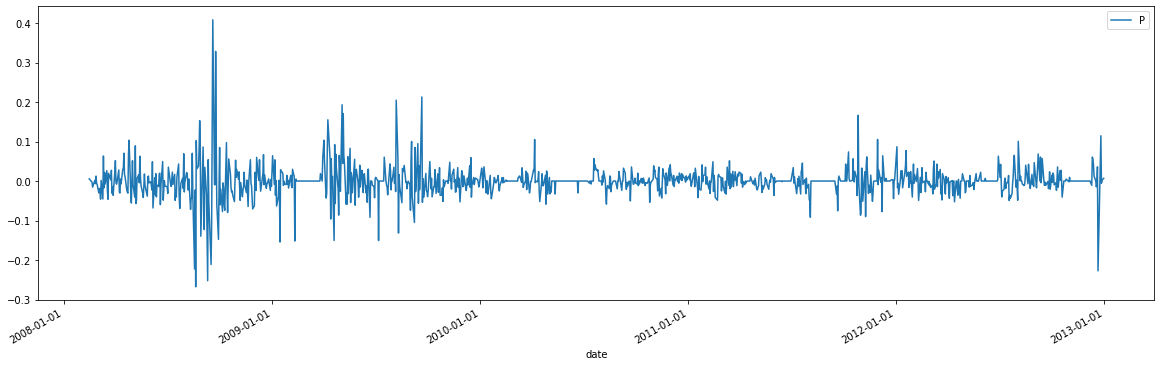

In [27]:
# Returns from Markowitz Portfolio
ax = PnL.plot(x_compat=True,figsize=[20, 6])
ax.xaxis.set_major_locator(mdates.YearLocator())
#ax.axhline(-0.001799,color="r")
ax.legend(("Portfolio Performance"))
plt.show()

### Cumulative Performance over time: Declining!

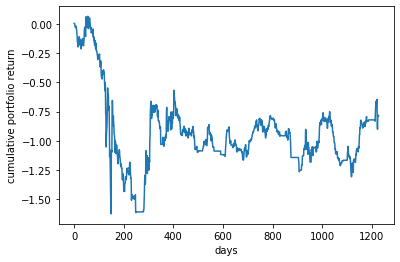

In [28]:
plt.plot(cumPnL)
plt.ylabel("cumulative portfolio return")
plt.xlabel("days")
plt.show()

### CONCLUSION: This signal model doesn't work well.

# Q3:
Now assume that the market impact of an order executed in a short time is proportional to the order's fraction of the total volume traded on that stock in the corresponding period. Write an optimizer that takes impact costs into account.

At each time t, the impact cost of a trade on stock i is 
$$TC_i = c \frac{Q_t^i}{V_t^i}$$ where $V_t^i$ is the total amount of shares traded on stock i in our market, and $c$ is an universal constant, and $Q_t^i$ is the amount of shares traded on stock i in our trading strategy at time t, i.e. order quantity.
* The optimal $w^*$ is a vector of weights $w_i^*$ less than 1, so assuming we invest $\$ $ 1 on our portfolio, the share amount traded on stock i is the amount of invested dollars over unit price:
$$Q_t^i = \frac{w_i^* \$ 1}{P_t^i} = \frac{\$ w_i^*}{P_t^i}$$
Then we have the impact cost as
$$TC_i = c \frac{\$ w_i^* }{V_t^i P_t^i}$$
So, got the data we need: Prices and Volumns:

In [29]:
allPrices2 = allPrices.iloc[1:] # drop first row with no corresponding return data
#allPrices2

In [30]:
allVols = Prices_SPY.drop(columns = {"SPY"})
for n in nums:
    condition = df["PERMNO"]==n
    dfi = df[condition]
    allVols[n] = dfi["VOL"]
    #print(len(allPrices[n].values))
allVols = allVols.replace(".",np.nan).astype(float)
allVols.index= pd.to_datetime(allVols.index,format="%Y%m%d")
allVols = allVols.iloc[1:]
#allVols
#allVols.isna().sum().values

Previously, we have Markowitz Optimization problem without Transaction Cost:
$$\min \ \ \frac{1}{2}w_t\Omega w - \mu(r_t)^T w \ \ \ s.t. \ \  \mathbf{u}^T w=1  $$
With Impact Cost $f(Q) = \triangle P = \sum\limits_{i=1}^{100}TC_i$ then we have:
$$\min \ \ \frac{1}{2}w_t\Omega w - \mu(r_t)^T w + f(Q)\ \ \ s.t. \ \  \mathbf{u}^T w=1  $$
plug in our definition of this linear transaction cost:
$$\min \ \ \frac{1}{2}w_t\Omega w - \mu(r_t)^T w + c\sum\limits_{i=1}^{100}(\frac{w^i}{P_t^iV_t^i})\ \ \ s.t. \ \  \mathbf{u}^T w=1  $$
Lets define a new vector:
$$\mathbf{v}_{Nx1} = [ \frac{1}{P_t^1V_t^1} \ \ \ \frac{1}{P_t^2V_t^2} \ \ \cdots \ \ \frac{1}{P_t^{100}V_t^{100}}     ]^T $$
then, our problem can be formulated as:
$$\min \ \ \frac{1}{2}w_t\Omega w - \mu(r_t)^T w + c\mathbf{v}^Tw\ \ \ s.t. \ \  \mathbf{u}^T w=1  $$
or,
$$\min \ \ \frac{1}{2}w_t\Omega w + (c\mathbf{v}^T- \mu(r_t)^T) w \ \ \ s.t. \ \  \mathbf{u}^T w=1  $$
### OPTIMIZER ONE:
#### In using ```cvxopt```Quandratic Programming solver like what we used in Q2, 
* we use $q_{Nx1} = c\mathbf{v}- \mu[r_t]$ instead of $- \mu[r_t]$.

In [31]:
# optimization with trading cost
def Optimizer_TC(v,mu,returns,covariance):
    '''
    v:          new nx1 vector defined above
                for simplisity, assume we can use mean of historical prices and volumns to estimate
                time t price and volumn traded on market
                
    mu:         mean of returns
    return:     vector of returns in window : allReturns.iloc[t:t+win].values.T
    covariance: omega 
    
    '''
    solvers.options['show_progress'] = False  
    n = len(returns) # 100 
    returns = np.asmatrix(returns)  
    
    # Convert to cvxopt matrices  
    P = opt.matrix(covariance)  # nxn
    q = opt.matrix(v-mu)  #nx1 ###########################
    
    # Create constraint matrices  
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix  
    h = opt.matrix(0.0, (n ,1))  # nx1 o vec
    A = opt.matrix(1.0, (1, n))  # nx1 unit vector^T
    b = opt.matrix(1.0,(1,1))          # scalar 1
    
    '''
    N = 100  
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)] 
    
    # Calculate efficient frontier weights using quadratic programming  
    portfolios = [solvers.qp(mu*P, q, A, b)['x'] for mu in mus] # G, h, 
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER  
    returns = [blas.dot(-q, x) for x in portfolios]  
    risks = [np.sqrt(blas.dot(x, P*x)) for x in portfolios]  
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE  
    m1 = np.polyfit(returns, risks, 2)  
    x1 = np.sqrt(m1[2] / m1[0])  
    
    # CALCULATE THE OPTIMAL PORTFOLIO  
    wt = solvers.qp(opt.matrix(x1 *P), q, G, h,  A, b)['x'] #
    '''
    wt = solvers.qp(P, q, G, h, A, b,)['x']# 
    return np.asarray(wt)

#### We dont have enough data for Volumns to track performance
* Print out the numbers of ***NaN*** in VOL data

In [43]:
# We dont have enough data for Volumns to track performance
num_NaNs = 0
for t in np.arange(1258-30):
    if allVols.iloc[30+t].isna().sum() !=0:
        num_NaNs+=allVols.iloc[30+t].isna().sum()
        #print(allVols.index[30+t],allVols.iloc[30+t].isna().sum())
print(num_NaNs)

6273


In [32]:
def performance_TC(w,start,window,c):
    '''
    w: weights from function optimal_portfolio(returns,covariance)
    
    return portfolio return-cost
    '''
    # TC coefficient vector
    cof = c* 1/allPrices2.iloc[start+window].values/allVols.iloc[start+window].values
    
    # we have some NaN in volumns data, so here use means to do estimate
    v_vec = c* 1/allPrices2.iloc[start:start+window].mean().values/allVols.iloc[start:start+window].mean().values
    
    return w.T.dot(allReturns.iloc[start+window]-v_vec)


def trackperformance_TC(win,c):
    '''
    win: window size
    c: constant for TC
    '''
    PnLs = []
    Betas = []
    
    for t in np.arange(len(allReturns)-win):
        
        # beta
        Bt = getBeta(CovarianceAssetToSPY(t,win),VarianceSPY(t,win))
        
        # Omega(Covariance)
        Sig2 = sigma2[t]
        omegat = Omega(Bt,Sig2,t,win)
        
        # inputs
        return_vec = allReturns.iloc[t:t+win].values.T
        covari_vec = omegat.values.T
        
        # mean of r
        mu = Bt["beta to SPY"].values * Returns_SPY.iloc[t:t+win].mean().values.item()
        
        # TC coefficient vector
        v_vec = c* 1/allPrices2.iloc[t:t+win].mean().values/allVols.iloc[t:t+win].mean().values
        
        print("[",t,":",t+win,"]")
        # optimization
        wt = Optimizer_TC(v_vec, mu, return_vec,covari_vec)
        
        # results
        Betas.append(Bt["beta to SPY"].values.T)
        PnLs.append(performance_TC(wt,t,win,c))
        print("start date is ",allReturns.index[t].strftime('%Y-%m-%d'), "target portfoio",t,"at ",allReturns.index[t+win].strftime('%Y-%m-%d'))
        #print("beta is ",Bt)
        print("PnL is ",performance_TC(wt,t,win,c))
        
    BT = pd.DataFrame(Betas,index = allReturns.index[win:],columns = nums)
    PnL = pd.DataFrame(PnLs,index = allReturns.index[win:],columns=["PnL"])
    
    return PnL,BT

In [33]:
#PnL_TC, BT_TC = trackperformance_TC(30,0.01)
#cumPnL_TC = np.cumsum(PnL_TC.values)

### OPTIMIZER TRIAL TWO:
* ```MOSEK``` package installation needed.

In [35]:
from mosek.fusion import *

def Optimizer_TC_Two(mu,Omega,v):
    
    """
    mu: An n dimensional vector of expected returns
    Omega: covariance of returns
    v: transaction cost per unit of invested dollar amount
    GT: standard deviation of portfolio, i.e. a matrix with n columns so (GT')*GT  = covariance matrix 
    gamma: Maximum risk (=std. dev) accepted

    Return: Optimal expected return and the optimal portfolio     
    """ 
    GT = np.linalg.cholesky(Omega)
    gamma = np.sqrt(0.5)
    
    with  Model("Markowitz with TC") as M:

        # Defines the variables (holdings). Assume no short position allowed.
        x = M.variable("x", 100, Domain.greaterThan(0.0))
        
        #  Maximize expected return
        M.objective('obj', ObjectiveSense.Maximize, Expr.dot(mu-v,x))
        
        # Sum of weights sum up to 1.
        M.constraint('budget', Expr.sum(x), Domain.equalsTo(1))
        
        # Limit of portfolio risk
        M.constraint('risk', Expr.vstack( gamma,Expr.mul(GT,x)), Domain.inQCone())

        # Solve
        M.solve()

        # return optimal weights
        return np.asarray(x.level())

In [ ]:
def trackperformance_TC_TWO(win,c):
    '''
    win: window size
    c: constant for TC
    '''
    PnLs = []
    Betas = []
    
    for t in np.arange(len(allReturns)-win):
        
        # beta
        Bt = getBeta(CovarianceAssetToSPY(t,win),VarianceSPY(t,win))
        
        # Omega(Covariance)
        Sig2 = sigma2[t]
        omegat = Omega(Bt,Sig2,t,win)
        
        # inputs
        return_vec = allReturns.iloc[t:t+win].values.T
        covari_vec = omegat.values.T
        
        # mean of r
        mu = Bt["beta to SPY"].values * Returns_SPY.iloc[t:t+win].mean().values.item()
        
        # TC coefficient vector
        v_vec = c* 1/allPrices2.iloc[t:t+win].mean().values/allVols.iloc[t:t+win].mean().values
        
        # optimization TWO
        wt = Optimizer_TC_Two(mu, covari_vec, v_vec)
        
        # results
        Betas.append(Bt["beta to SPY"].values.T)
        PnLs.append(performance_TC(wt,t,win,c))
        print("start date is ",allReturns.index[t].strftime('%Y-%m-%d'), "target portfoio",t,"at ",allReturns.index[t+win].strftime('%Y-%m-%d'))
        #print("beta is ",Bt)
        print("PnL is ",performance_TC(wt,t,win,c))
        
    BT = pd.DataFrame(Betas,index = allReturns.index[win:],columns = nums)
    PnLs = pd.DataFrame(PnLs,index = allReturns.index[win:],columns=["PnL"])
    
    return PnLs